In [1]:
import matplotlib.pyplot as plt 
import torch 
from ops import grid2d_coords, grid1d_coords
from ops import fetch_nbrs1d
from ops import interp1d
from ops import injection1d
from ops import restrict1d
from utils import rl2_error, matrl2_error
from mlmm import Grid1D 
from mlmm import kernel_func_2D, ffunc_1D
from mlmm import MLMM1D

In [2]:
n = 15
m = 3
k = 7

In [5]:
mlmm1d = MLMM1D(n,m,1)
f_h = ffunc_1D(mlmm1d.ml_grids[0].x_h).T[None].repeat(7,1,1)
mlmm1d.restrict_ml_f(f_h)
finest_grid = mlmm1d.ml_grids[0]
fh = torch.squeeze(mlmm1d.ml_f[0]).T
nh = finest_grid.nh
hh = finest_grid.hh
finest_grid.init_grid_hh()
finest_pts = finest_grid.x_hh.reshape(-1,2)
Khh = kernel_func_2D(finest_pts).reshape(nh, nh)
uh = hh * (Khh @ fh).T

finest grid : 65537
coarest grid : 32769


In [3]:
for k in range(7):
    mlmm1d = MLMM1D(n,m,k)
    f_h = ffunc_1D(mlmm1d.ml_grids[0].x_h).T[None].repeat(7,1,1)
    mlmm1d.restrict_ml_f(f_h)
    mlmm1d.eval_ml_K(kernel_func_2D)
    uh_ = mlmm1d.ml_kint()

finest grid : 65537
coarest grid : 513


In [27]:
finest_grid = mlmm1d.ml_grids[0]
fh = torch.squeeze(mlmm1d.ml_f[0]).T
nh = finest_grid.nh
hh = finest_grid.hh
finest_grid.init_grid_hh()
finest_pts = finest_grid.x_hh.reshape(-1,2)
Khh = kernel_func_2D(finest_pts).reshape(nh, nh)
uh = hh * (Khh @ fh).T

In [28]:
print("m {:} : {:.4e} ".format(2*m, rl2_error(uh_, uh).numpy()))

m 6 : 1.7608e-04 


In [29]:
%%timeit
uh = hh * (Khh @ fh).T

479 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
uh_ = mlmm1d.ml_kint()

50.2 ms ± 563 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
u_h = mlmm1d.coarest_full_kint()
K_IJ = torch.squeeze(mlmm1d.K_HH[mlmm1d.ml_grids[-1].ij_idx])
print(K_IJ.shape)

l = 1
nh = mlmm1d.ml_grids[-1-l].nh
hh = mlmm1d.ml_grids[-1-l].hh
f_h = torch.squeeze(mlmm1d.ml_f[-1-l]).T

K_local_even, K_local_odd = mlmm1d.K_locals[l-1]
idx_corr_even, idx_corr_odd = mlmm1d.local_idx[l-1]
K_ij = K_local_assemble_2D(K_IJ, K_local_even, K_local_odd)
K_2Ij = K_ij[::2]

# local kernel interpolation
K_local_even_, K_local_odd_ = K_local_interp_2D(K_IJ, K_2Ij)
# calculate difference
K_corr_even = K_local_even.reshape(-1) - K_local_even_
K_corr_odd = K_local_odd.reshape(-1) - K_local_odd_

# correct even 
K_corr_even_sparse = torch.sparse_coo_tensor(idx_corr_even, K_corr_even,(nh,nh))
u_corr_ = torch.sparse.mm(K_corr_even_sparse, f_h).T
u_corr_ = hh * injection1d(u_corr_[None,None])[0,0]
u_h_ = u_h + u_corr_
u_h_ = interp1d(u_h_[:,None])[:,0]

# correct odd 
K_corr_odd_sparse = torch.sparse_coo_tensor(idx_corr_odd, K_corr_odd,(nh,nh))
u_corr_ = hh*torch.sparse.mm(K_corr_odd_sparse, f_h).T
u_h_ = u_h_ + u_corr_

# get new K_IJ, u_h
K_IJ = K_ij[:,self.m:-self.m]
u_h = u_h_

torch.Size([33, 7])
torch.Size([33, 6]) torch.Size([33, 6])


NameError: name 'self' is not defined

In [22]:
u_h_.shape

torch.Size([7, 65])

In [7]:
f_h.shape

torch.Size([7, 1, 65])

In [10]:
# eval kernel at coarest level
K_hh = kernel_func_2D(mlmm1d.coarest_pts)

# eval kernel integral at coarest level
nH = mlmm1d.ml_grids[-1].nh
HH = mlmm1d.ml_grids[-1].hh
f_h = mlmm1d.ml_f[-1]
u_h = HH * (K_hh.reshape(nH, nH) @ torch.squeeze(f_h).T).T

# direct interp
u_interp = u_h
for l in range(k):
    u_interp = interp1d(u_interp[None])[0]
print("wo : {:.4e} ".format(matrl2_error(u_interp, u_ref).numpy()))


wo : 1.4853e-01 


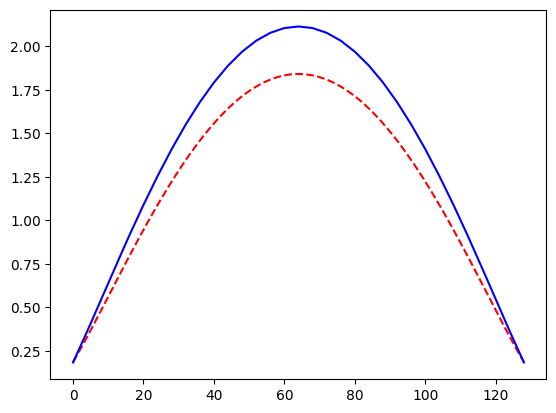

In [13]:
plt.plot(u_ref[0], '--r')
plt.plot(u_interp[0], '-b')

In [17]:
# multi-level correction
ml_grids = ml_grids[::-1]
ml_f = ml_f[::-1]
K_IJ = K_hh[coarest_grid.ij_idx]
K_IJ = torch.squeeze(K_IJ)

NameError: name 'K_hh' is not defined

In [16]:
for l in range(k):
    nh = ml_grids[l+1].nh
    hh = ml_grids[l+1].hh
    f_h = ml_f[l+1]

    # local kernel evaluation
    idx_corr_even, idx_corr_odd = ml_grids[l].fetch_local_idx()
    x_2Ij = ml_grids[l].fetch_K_local_x()
    K_local_even, K_local_odd = K_local_eval_2D(x_2Ij, kernel_func_2D)
    K_ij = K_local_assemble_2D(K_IJ, K_local_even, K_local_odd)
    K_2Ij = K_ij[::2]
    
    # local kernel interpolation
    K_local_even_, K_local_odd_ = K_local_interp_2D(K_IJ, K_2Ij)

    # calculate difference
    K_corr_even = K_local_even.reshape(-1) - K_local_even_
    K_corr_odd = K_local_odd.reshape(-1) - K_local_odd_

    # correct even 
    K_corr_even_sparse = torch.sparse_coo_tensor(idx_corr_even, K_corr_even,(nh,nh))
    u_corr_ = torch.sparse.mm(K_corr_even_sparse, f_h.reshape(-1,1)).reshape(nh)
    u_corr_ = hh * injection1d(u_corr_[None,None])[0,0]
    u_h_ = u_h + u_corr_
    u_h_ = interp1d(u_h_[None,None])[0,0]
    
    # correct odd 
    K_corr_odd_sparse = torch.sparse_coo_tensor(idx_corr_odd, K_corr_odd,(nh,nh))
    u_corr_ = hh*torch.sparse.mm(K_corr_odd_sparse, f_h.reshape(-1,1)).reshape(nh)
    u_h_ = u_h_ + u_corr_

    # get new K_IJ, u_h
    K_IJ = K_ij[:,m:-m]
    u_h = u_h_

print("m {:} : {:.4e} ".format(2*m, rl2_error(u_h, u_ref).numpy()))

NameError: name 'K_IJ' is not defined